随便写的

IndexError: list index out of range

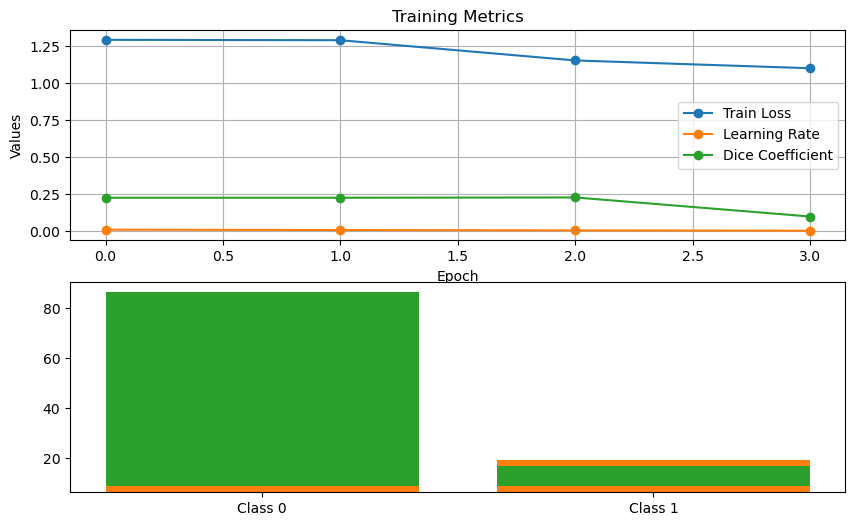

In [1]:
import matplotlib.pyplot as plt

epochs = [0, 1, 2, 3]
train_losses = [1.2939, 1.2912, 1.1544, 1.1017]
lrs = [0.010000, 0.007719, 0.005359, 0.002872]
dice_coefficients = [0.226, 0.226, 0.228, 0.099]
mean_ious = [6.4, 6.4, 8.9, 42.8]

# 折线图设置
plt.figure(figsize=(10, 6))  # 调整图片大小

plt.subplot(2, 1, 1)  # 上方子图：训练指标
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, lrs, label='Learning Rate', marker='o')
plt.plot(epochs, dice_coefficients, label='Dice Coefficient', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)

# 条形图设置
plt.subplot(2, 1, 2)  # 下方子图：IoU
bar_labels = ['Class 0', 'Class 1']  # 标签
iou_by_epoch = [[0.0, 12.7], [5.0, 12.9], [77.4, 8.1]]  # 每轮的 IoU 数据

for i in range(len(epochs)):
    plt.bar(bar_labels, iou_by_epoch[i], label=f'Epoch {i}', bottom=mean_ious[i])

plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
